# Training tutorial

In [96]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import torch
import torch_geometric
import yaml

import jeans_gnn as jgnn

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read the dataset

As a first step, we read the preprocessed dataset of projected galaxy kinematics.
For each galaxy, we will construct a k-nearest neighbor graph.

As an example, here we will only read in the training set.

In [97]:
# Read the training and validation datasets
dataset_name = 'mini_gNFW_Plummer_OM_poisson100'
dataset_path = jgnn.utils.paths.find_dataset(
    dataset_name, flag='train')
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'labels'])
num_galaxies = headers['num_galaxies']

# print all headers of the training dataset
print('Headers:')
for k, v in headers.items():
    print('- {}: {}'.format(k, v))


Headers:
- all_features: ['pos' 'vel' 'vel_error' 'dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm'
 'dm_rho_0' 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- dataset_name: mini_gNFW_Plummer_OM_poisson100
- date: 2023-04-14 11:23:34
- df_type: QuasiSpherical
- dm_type: Spheroid
- error_los: 0
- flag: train
- galaxy_name: mini_gNFW_Plummer_OM_poisson100
- graph_features: ['dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm' 'dm_rho_0'
 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- labels_order: ['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
- name: mini
- node_features: ['pos' 'vel' 'vel_error']
- num_galaxies: 900
- projection: 0
- stellar_type: Plummer
- train_frac: 0.9


The node features include the position and line-of-sight velocity of each star
in the galaxy. From this, we can construct a k-nearest neighbor graph.

In this example, we set k=5, which means that each star is connected to its
5 nearest neighbors.

In [98]:
# Construct an object for data transformation
# graph construction based on torch_geometric.transforms.KNNGraph
# https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.KNNGraph

transform = jgnn.gnn.transforms.PhaseSpaceGraphProcessor(
    graph_name="KNNGraph",
    graph_params={
        "k": 5, 
        "force_undirected": True, 
        "loop": False
    },
    log_radius=True,
)

In [99]:
# Iterate over the training dataset
# and transform each graph to torch_geometric.data.Data
# https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data

data_list = []
for i in range(num_galaxies):
    data = transform(
        pos=node_features['pos'][i],
        vel=node_features['vel'][i],
        label=graph_features['labels'][i],
    )
    data_list.append(data)

# Construct a data loader
# https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.DataLoader

dataloader = torch_geometric.loader.DataLoader(
    data_list, batch_size=32, shuffle=True)

Plot a few example graphs. The stars are color-coded based on their 
line-of-sight velocities, with blue being out-of-the page and red being into-the-page.

Epoch 617:   0%|          | 0/1 [13:14<?, ?it/s, loss=0.754, v_num=]


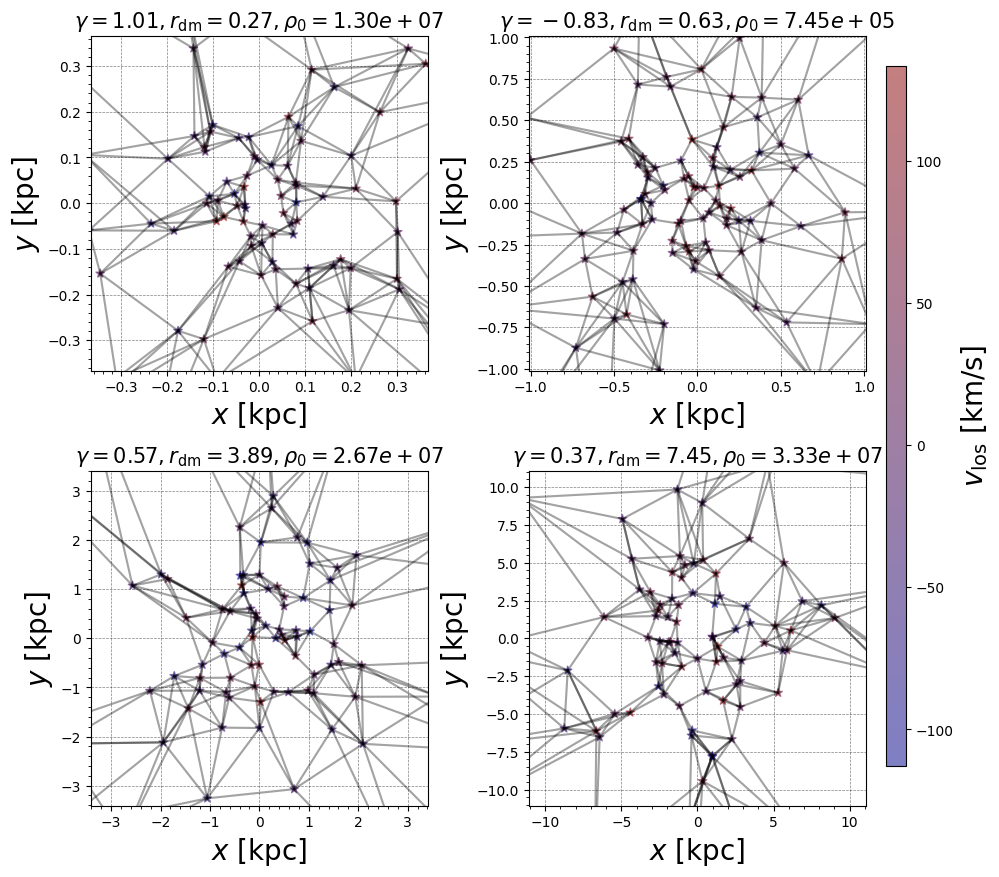

In [100]:
# randomly choose 4 galaxies
indices = np.random.randint(0, len(data_list), 4)

# start plotting
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# some plotting parameters
s = 40
marker = '*'
# create a colormap by adding gradients between colors
color1 = 'darkblue'
color2 = 'darkred'
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'mycmap', [color1, color2])


for i, idx in enumerate(indices):
    ax = axes[i // 2, i % 2]

    # get a random galaxy and transform it to a graph
    pos = data_list[idx].pos.numpy()  # 2d positions
    vel = data_list[idx].x[:, 1].numpy()  # los velocity
    labels = data_list[idx].y[0].numpy()

    data = transform(pos, vel)

    # set title to be parameters gamma, r_dm, rho_0,
    title = r'$\gamma={:.2f}, r_{{\rm dm}}={:.2f}, \rho_0={:.2e}$'.format(
        labels[0], 10**labels[1], 10**labels[2])
    box_size = 2 * 10**labels[3]

    # create a log scale for the colorbar
    norm = mpl.colors.Normalize(vmin=vel.min(), vmax=vel.max())

    # plot the nodes
    sc = ax.scatter(pos[:, 0], pos[:, 1], c=vel, norm=norm, s=s, 
                    marker=marker, cmap=cmap, alpha=0.5)
    ax.set_xlim(-box_size, box_size)
    ax.set_ylim(-box_size, box_size)

    # plot the edges
    for i in range(data.edge_index.shape[1]):
        x1, y1 = data.pos[data.edge_index[0, i]]
        x2, y2 = data.pos[data.edge_index[1, i]]
        ax.plot([x1, x2], [y1, y2], c='black', alpha=0.2)

    # add labels
    ax.set_xlabel(r'$x$ [kpc]', fontsize=20)  
    ax.set_ylabel(r'$y$ [kpc]', fontsize=20)
    ax.set_title(title, fontsize=15)

    # add major grid and minor ticks
    ax.grid(which='major', linestyle='--', linewidth='0.5', 
            alpha=0.5, color='black')
    ax.minorticks_on()

# add a colorbar to the right of the figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label(r'$v_{\rm los}$ [km/s]', fontsize=20)

# adjust the spacing between subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

## Training

We will now train a GraphRegressor model to predict the dark matter halo 
density based on the projected galaxy kinematics. Using JeansGNN, we can easily construct a GraphRegressor model with the DensitySampler wrapper.

In [101]:
# First, we construct a DensitySampler object from a config file
# The config file is a yaml file that contains all the parameters
# for the model, training, and validation
# An example config file is provided in configs/example_training.yaml
sampler = jgnn.density_sampler.DensitySampler(
    run_name='example_training', 
    config_file='configs/example_training.yaml')

In [102]:
# We can also construct a DensitySampler object from a dictionary
# The dictionary should contain all the parameters for the model,
# training, and validation

# In this example, we read the config file and convert it to a dictionary
with open('configs/example_training.yaml', 'r') as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
model_params = config_dict['model']
optimizer_params = config_dict['optimizer']
scheduler_params = config_dict['scheduler']
transform_params = config_dict['transform']

# Construct a DensitySampler object
# Note that if resume=False, the DensitySampler will overwrite
# the existing run directory
sampler = jgnn.density_sampler.DensitySampler(
    run_name='example_training',
    model_params=model_params,
    optimizer_params=optimizer_params,
    scheduler_params=scheduler_params,
    transform_params=transform_params,
    resume=False
)

In [104]:
# Now we can start training
# In this simple example, we will not use the validation set
# and we will save the top 5 models based on the validation loss
# If a GPU is available, the DensitySampler will automatically
# use it for training
sampler.fit(
    train_loader=dataloader,
    val_loader=None,
    batch_size=128,
    num_workers=1,
    max_epochs=10,
    save_top_k=5,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | GraphRegressor | 441 K 
-----------------------------------------
441 K     Trainable params
0         Non-trainable params
441 K     Total params
1.765     Total estimated model params size (MB)
/mnt/home/tnguyen/miniconda3/envs/conda-torch/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory example_training/lightning_log/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Epoch 9: 100%|██████████| 29/29 [00:00<00:00, 39.17it/s, loss=-0.371, v_num=] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 29/29 [00:00<00:00, 38.61it/s, loss=-0.371, v_num=]


In [105]:
# After training, we sample the DM density of the training set as 
# an example
num_samples = 1000  # number of posterior samples
posteriors, truths = sampler.sample(
    loader=dataloader,
    batch_size=128,
    num_workers=1,
    num_samples=1000,
    return_labels=True,
)

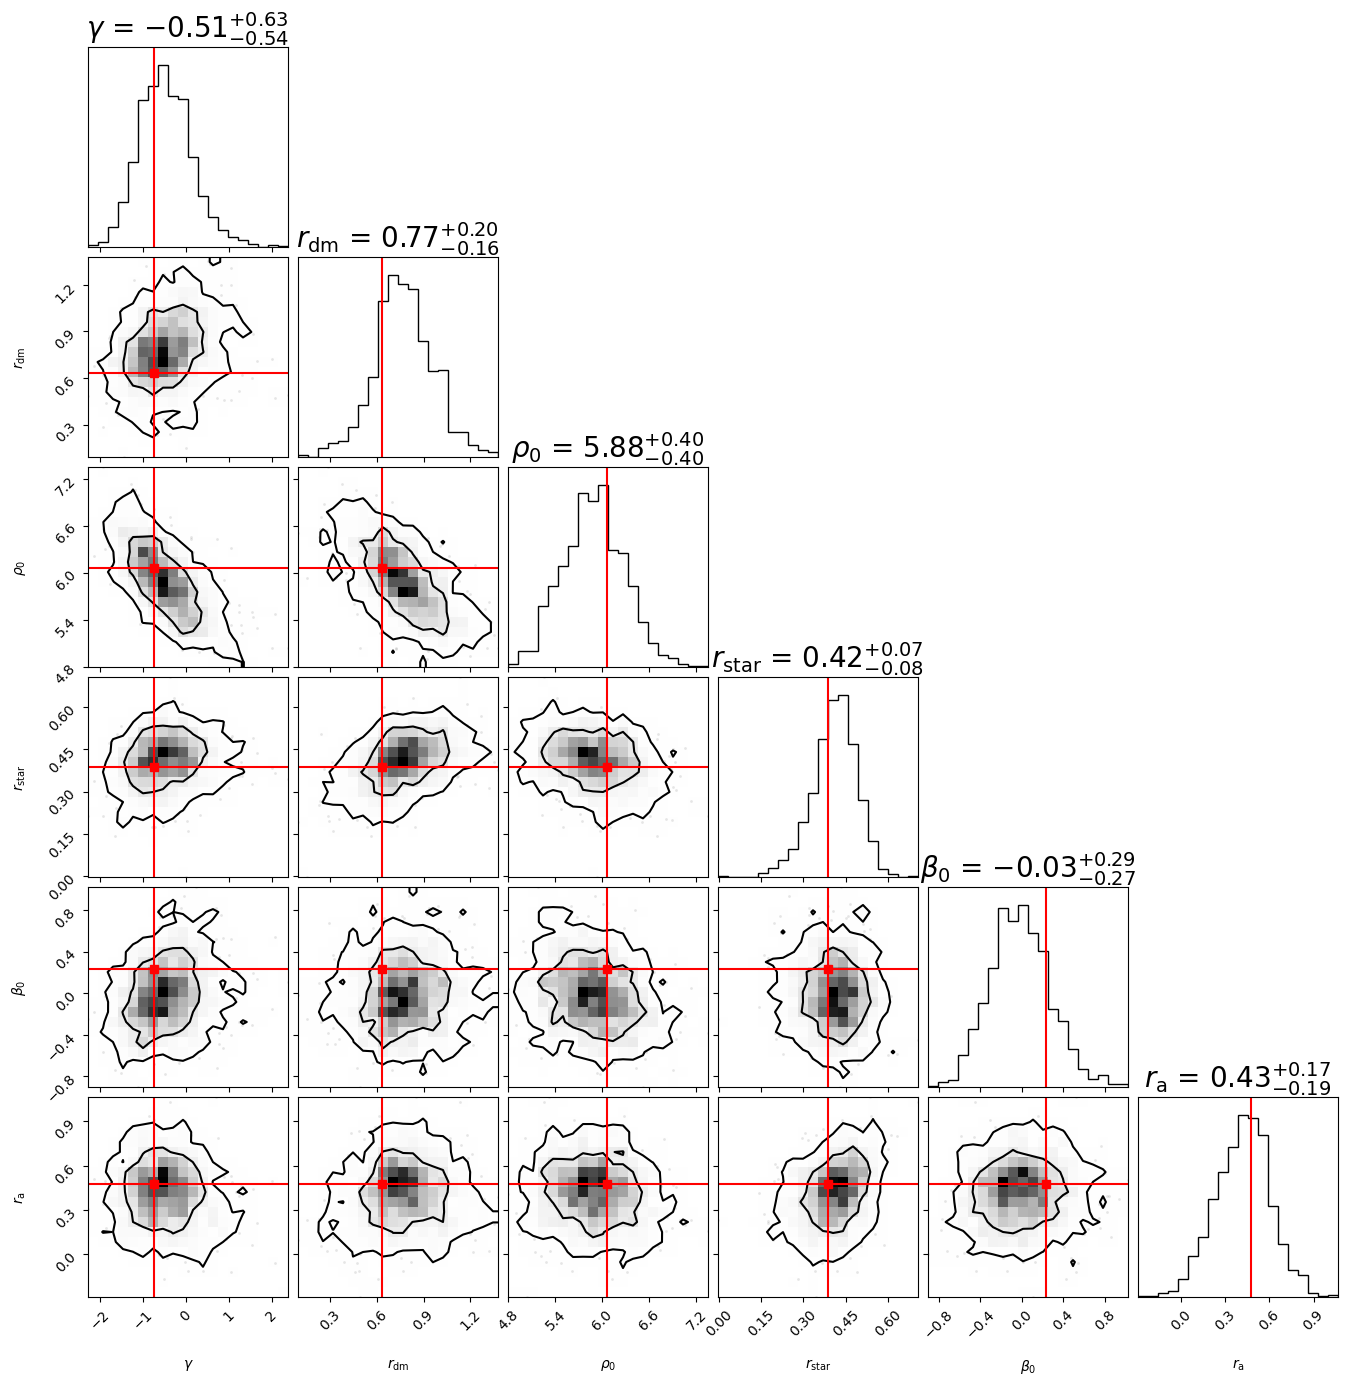

In [106]:
# plot corner plot of a chosen idx
idx = 6
labels = [
    r'$\gamma$', r'$r_{\rm dm}$', r'$\rho_0$', r'$r_{\rm star}$',
    r'$\beta_0$', r'$r_{\rm a}$'
]
corner_args =dict(
    truth_color='red',
    labels=labels,
    show_titles=True,
    title_kwargs={'fontsize': 20},
    smooth=0.5,
    levels=(0.68, 0.95),
)

fig = corner.corner(
    posteriors[idx], truths=truths[idx],
    **corner_args
)
